## **Intro**

The analysed dataset is a Developer Survey data of 2022 year.
The dataset contains responses to an annual survey conducted by StackOverflow. You can find the official analysis of the data here: https://insights.stackoverflow.com/survey. The dataset contains over 70,000 responses to 60 questions, fielded from over 180 countries.

As it is a survey of one year, this is a cross-sectional data. But before we will start modeling and testing it, we will perform an EDA, to understand what information is in the dataset, how can we deal with it and state better hypothesis about this data.



In [3]:
!pip install -U pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd

from pathlib import Path

import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 

import plotly.io as pi
pi.renderers.default = "colab"

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file

In [5]:
def load_df(path):
    """
    Load a DataFrame from a CSV file.

    Args:
        path (str): The file path of the CSV file.

    Returns:
        pandas.DataFrame: The loaded DataFrame.
    """

    # read the CSV file into a DataFrame
    df = pd.read_csv(path)
    return df


In [6]:
df_survey_2022 = load_df("survey_results_public2022.csv")

In [7]:
df_survey_2022.head()

ResponseId                                         MainBranch  \
0           1                                      None of these   
1           2                     I am a developer by profession   
2           3  I am not primarily a developer, but I write co...   
3           4                     I am a developer by profession   
4           5                     I am a developer by profession   

            Employment                            RemoteWork  \
0                  NaN                                   NaN   
1  Employed, full-time                          Fully remote   
2  Employed, full-time  Hybrid (some remote, some in-person)   
3  Employed, full-time                          Fully remote   
4  Employed, full-time  Hybrid (some remote, some in-person)   

                           CodingActivities  \
0                                       NaN   
1  Hobby;Contribute to open-source projects   
2                                     Hobby   
3              I don’t code outside of work   
4                                     Hobby   

                                           EdLevel  \
0                                              NaN   
1                                              NaN   
2  Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
3     Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
4     Bachelor’s degree (B.A., B.S., B.Eng., etc.)   

                                           LearnCode  \
0                                                NaN   
1                                                NaN   
2  Books / Physical media;Friend or family member...   
3  Books / Physical media;School (i.e., Universit...   
4  Other online resources (e.g., videos, blogs, f...   

                                     LearnCodeOnline LearnCodeCoursesCert  \
0                                                NaN                  NaN   
1                                                NaN                  NaN   
2  Technical documentation;Blogs;Programming Game...                  NaN   
3                                                NaN                  NaN   
4  Technical documentation;Blogs;Stack Overflow;O...                  NaN   

  YearsCode  ... TimeSearching TimeAnswering Onboarding ProfessionalTech  \
0       NaN  ...           NaN           NaN        NaN              NaN   
1       NaN  ...           NaN           NaN        NaN              NaN   
2        14  ...           NaN           NaN        NaN              NaN   
3        20  ...           NaN           NaN        NaN              NaN   
4         8  ...           NaN           NaN        NaN              NaN   

  TrueFalse_1 TrueFalse_2 TrueFalse_3           SurveyLength  \
0         NaN         NaN         NaN                    NaN   
1         NaN         NaN         NaN               Too long   
2         NaN         NaN         NaN  Appropriate in length   
3         NaN         NaN         NaN  Appropriate in length   
4         NaN         NaN         NaN               Too long   

                   SurveyEase ConvertedCompYearly  
0                         NaN                 NaN  
1                   Difficult                 NaN  
2  Neither easy nor difficult             40205.0  
3                        Easy            215232.0  
4                        Easy                 NaN  

[5 rows x 79 columns]

After loading dataset we will choose 12 columns of it to process, as from our analysis they are the most relevant and are not dublicated in their meanings.

The droped columns will be:
*  Not relevant for our modeling, like *ResponseId* as we have cross-sectional data, *TimeAnswering*, *TimeSearching*, *SurveyLength*, *SurveyEase*, etc.
*  Highly correlated, like *YearsCode* and *YearsCodePro* (look at the code below) with obviouse high correlation.
* With same or simular meaning, like *MainBranch* and *CodingActivities*, that have predictable connection.

In [8]:
df_test = load_df("survey_results_public2022.csv")
df_test['YearsCode'] = pd.to_numeric(df_test['YearsCode'], errors='coerce')
df_test['YearsCodePro'] = pd.to_numeric(df_test['YearsCodePro'], errors='coerce')
corr_years_code = df_test['YearsCode'].corr(df_test['YearsCodePro'])
print(corr_years_code)

0.9124935811319272


In [9]:
selected_vars = ["ConvertedCompYearly" ,"RemoteWork", "EdLevel", "YearsCodePro", "DevType", "MainBranch", "Employment", "OrgSize", "Country", "LanguageHaveWorkedWith", "Age", "Gender", "MentalHealth"]

In [10]:
df_survey_2022 = df_survey_2022[selected_vars]

In [11]:
df_survey_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73268 entries, 0 to 73267
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ConvertedCompYearly     38071 non-null  float64
 1   RemoteWork              58958 non-null  object 
 2   EdLevel                 71571 non-null  object 
 3   YearsCodePro            51833 non-null  object 
 4   DevType                 61302 non-null  object 
 5   MainBranch              73268 non-null  object 
 6   Employment              71709 non-null  object 
 7   OrgSize                 51039 non-null  object 
 8   Country                 71771 non-null  object 
 9   LanguageHaveWorkedWith  70975 non-null  object 
 10  Age                     70946 non-null  object 
 11  Gender                  70853 non-null  object 
 12  MentalHealth            66447 non-null  object 
dtypes: float64(1), object(12)
memory usage: 7.3+ MB


***ConvertedCompYearly*** - is a converted from different currencies to USA dollars the anual salary of the interviewee. This will be our dependent variable, so as we can see from this analysis output, there are some Nan values in it (only 38071 are not Nan). So we would have to drop those observations. However, there are still quite many observations left, so it will not be a problem.

***RemoteWork*** - is a type of mode that the interviewee is working on (remote, hybrid, in-person...)

***EdLevel*** - is a level of education that the interviewee has.

***YearsCodePro*** - is an amount of years that the interviewee is coding as a professional (professional experience in coding).

***DevType*** - is a type of the developer the interviewee is.

***MainBranch*** - is a main field of work of the interviewee.

***Employment*** - is an employment status of the interviewee.

***OrgSize*** - is a size of the organization, that the interviewee is working at.

***Country*** - is a country of living of the interviewee.

***LanguageHaveWorkedWith*** - is a language or a group of programming languages that the interviewee knows and have worked with.

***Age*** - is an age of the interviewee.

***Gender*** - is a gender of the interviewee.

***MentalHealth*** - is a representation of the mental health of the interviewee.

## Analyze Countries

Let's examine the number of countries represented in the survey replies.

In [12]:
# count the number of responses from each country
countries = pd.DataFrame(df_survey_2022.Country.value_counts()).reset_index()

You can see in the table below that there is a high number of responses that  are from the US. Also, we can already see that the survey might not be entirely representative of the world's programming community, particularly among nations that do not use the English language.

In [13]:
countries

index  Country
0                             United States of America    13543
1                                                India     6639
2                                              Germany     5395
3    United Kingdom of Great Britain and Northern I...     4190
4                                               Canada     2490
..                                                 ...      ...
175                                             Monaco        1
176                                           Djibouti        1
177                                         Seychelles        1
178                                    Solomon Islands        1
179                              Saint Kitts and Nevis        1

[180 rows x 2 columns]

In [14]:
def create_choropleth(df, countries, var, title, max_z=5000):
  data = dict(
          type = 'choropleth',
          colorscale = 'Viridis',
          reversescale = True,
          locations = df[countries],
          locationmode = "country names",
          z = df[var],
          text = df[countries],
          colorbar = {'title' : var},
          autocolorscale = True,
          zmin=0,
          zmax=max_z
        ) 
  layout = dict(title = title,
                geo=dict(
          showframe=False,
          showcoastlines=False,
          projection_type='equirectangular'
          )
               )
  return data, layout

def plot_choropleth(data, layout):
  choromap = go.Figure(data = [data],layout = layout)
  iplot(choromap,validate=False)

Visual representation:

In [15]:
data_country, layout_country = create_choropleth(countries, "index", "Country", "No. of Respondents in Countries")
plot_choropleth(data_country, layout_country)

## Age

The age can be a crucial factor when talking about a salary. Most companies want to hire young people, who have more energy and creativity. But the experience and wisdom is also an important factor.

So firstly, let's look how many different values we have for age question and how many observation of each value there are in our dataset. This would be more convenient to see by visualizing using a histogram.

In [16]:
px.histogram(df_survey_2022, x="Age", title='Age of Respondents')

As we can see from this graph, the most answers are received from the people at the age from 25 to 34 years (more than one third of all data).
Then we have the age from 18 to 24 years and the third biggest group is from 35 to 44 years old.

Also as we can see there are a few observations of people under 18 and the rest are 45+ aged (+ prefered not to say).

From this we can make a hypothesis, that in the field of development there are more young people approximately from 20 to 40 years.

In [17]:
young_dev = df_survey_2022.loc[(df_survey_2022['Age'] == '25-34 years old') & (df_survey_2022['ConvertedCompYearly'] >= 50000)]
len(young_dev)

11079

As we can see, almost a half of the respondents in age 25-34 years are earning more than 50k USD a year.

## Gender

Let's have a look at the gender response distribution.

As you can see on the histogram, the programming community is moslty represented by men. As expected, women and non-binary personas are severely underrepresented.

In [18]:
px.histogram(df_survey_2022, x="Gender", title='Gender of Respondents')

## Education Level

A significant part in positive result of becoming a developer, depends on formal education in computer science field. It is important for the job position and therefore for the amount of salary. However, there are a numerous amount of free resources and tutorials that can be found online to acquire programming skills.

To gain valuable insights on this matter, let's see what types of education the respondents have.

In [19]:
px.histogram(df_survey_2022, x="EdLevel", title='Education Level of Respondents')

As we can see the main part of all observations (almost the half) is a group of people with Bachelor's degree, which can correspond to the group of people in the age form 25 to 34 (almost 50% of all observations).

The approximately same amount (~20k) of people, who has a Master's degree or other type of degree and the poeple, who has School education or College/University education without degree.

This output was quite expected due to the analysis of the age contribution:
* ~30k of people of the age 25-34 - Bachelor's degree
* ~20k of people of the age under 18-24 - School or College/University education without degree
* ~20k of people of the age 35+ - Master's and other degrees

## Development Type

Let's analyze which roles our respondents hold.

In [20]:
def split_cols(df):
    df_res = df.to_frame()
    options = []
    for i, value in df[df.notnull()].items():
        option_list = value.split(';')
        for option in option_list:
            if not option in df_res.columns:
                options.append(option)
                df_res[option] = 0
            df_res.at[i, option] = 1
    return df_res[options]

In [21]:
dev_type = split_cols(df_survey_2022.DevType)
dev_type_totals = dev_type.sum().sort_values(ascending=False)

On the barplot we can see that most of the respondents work as full-stack and back-and developers. On the third position is front-end.

Text(0.5, 0, 'count')

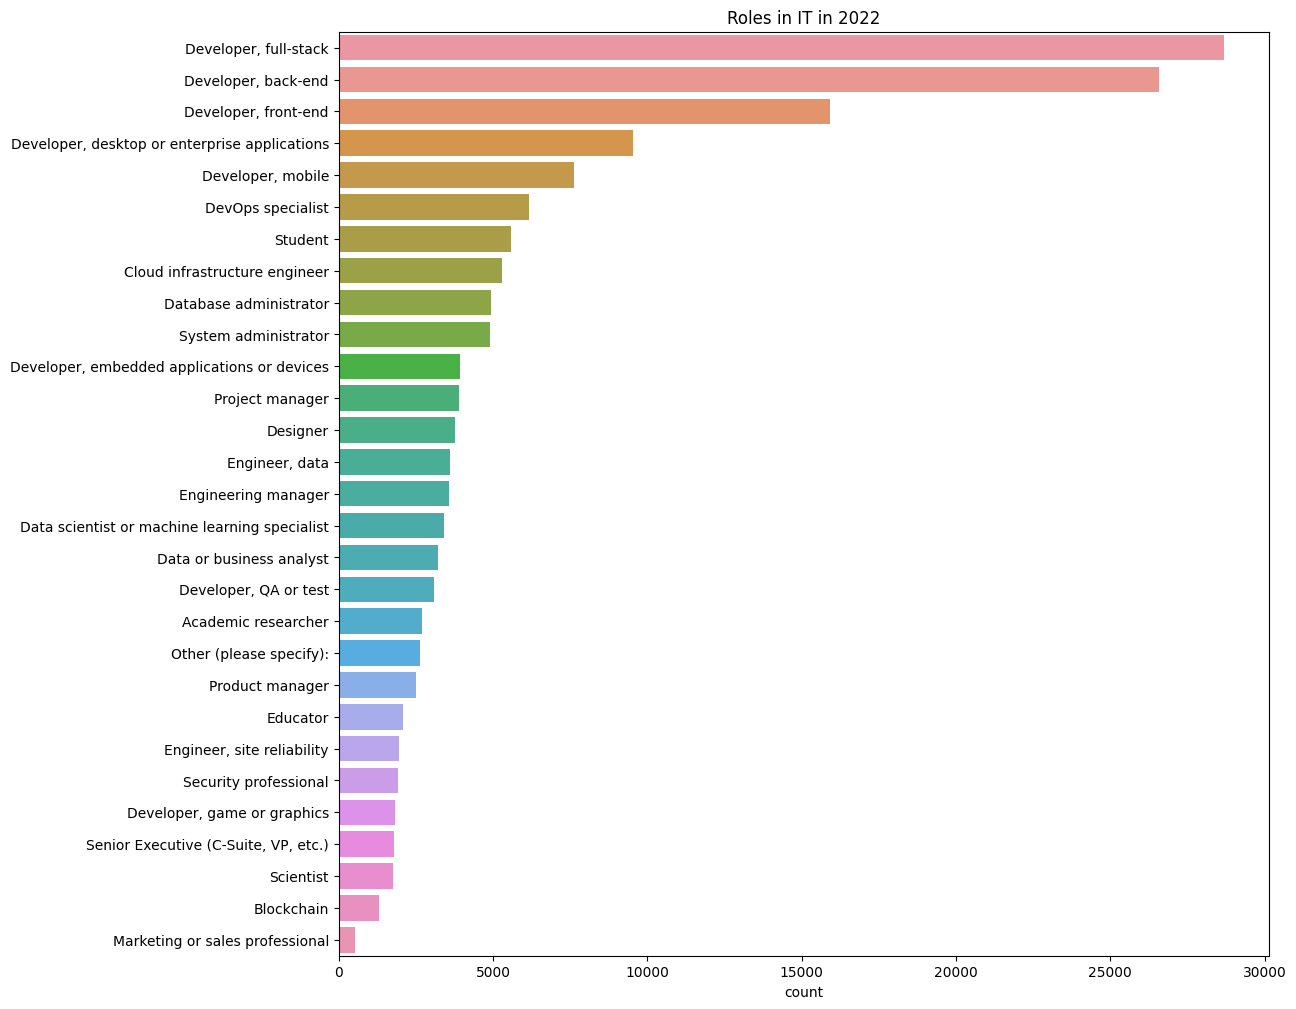

In [22]:
plt.figure(figsize=(12, 12))
sns.barplot(x=dev_type_totals, y=dev_type_totals.index)
plt.title("Roles in IT in 2022")
plt.xlabel('count')

As we can see, the 5 most "popular" programming roles are:
1. *Developer, full-stack* - more than 20k
2. *Developer, back-end* - more than 18k
3. *Developer, front-end* - almost 11k
4. *Developer, desktop or enterprise applications* - more than 6k
5. *Developer, mobile* - almost 5k

## Programming languages

The programming language is the crutial and logically valuable factor for the amount of the salary of the developer.

The more languages is known the better position can be taken and the bigger salary can be received. However, we also know, that in different fields, different programming languages are needed. So not only the amount of languages, but also the types of languages the respondent knows can be the determining factor of the amount of salary of such specialist.

In [23]:
languages_worked_df = split_cols(df_survey_2022.LanguageHaveWorkedWith)
languages_worked_percentages = languages_worked_df.mean().sort_values(ascending=False) * 100

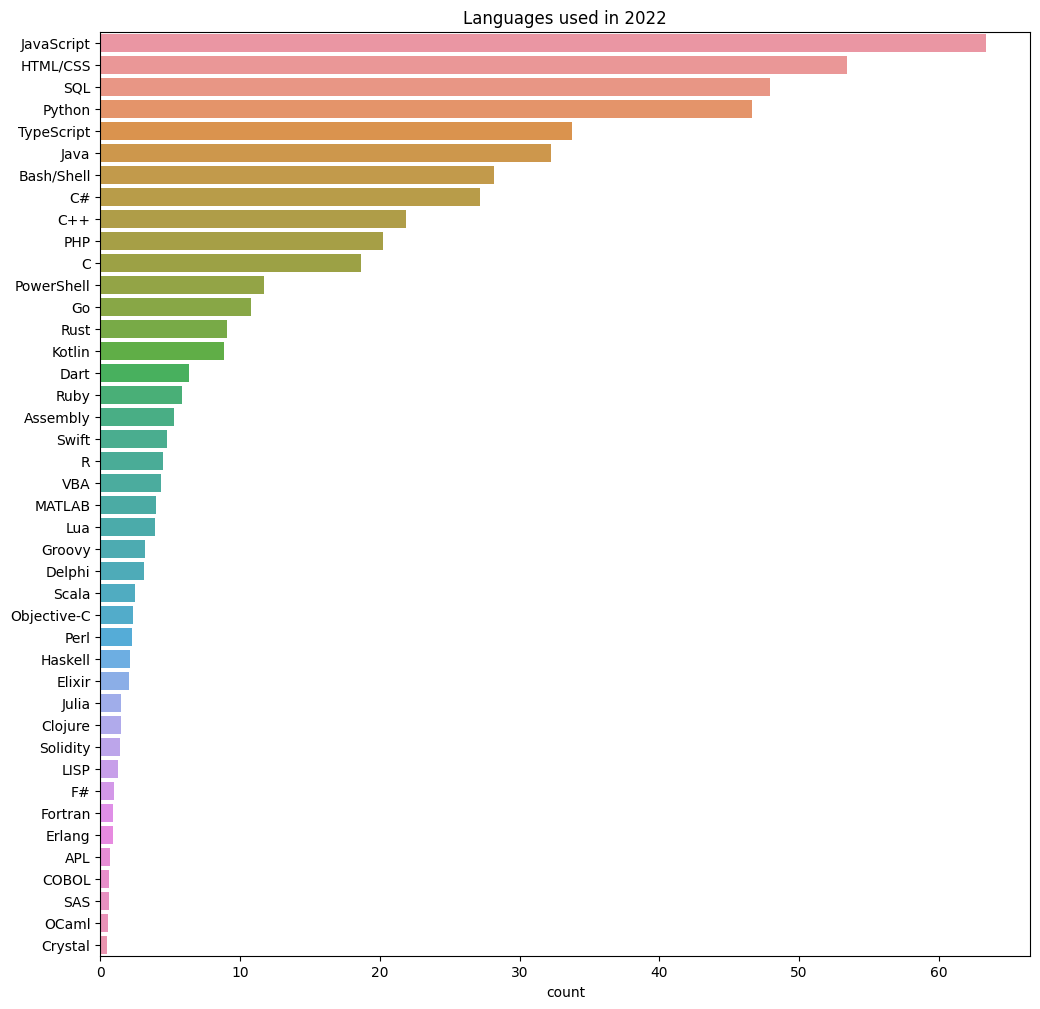

In [25]:
plt.figure(figsize=(12, 12))
sns.barplot(x=languages_worked_percentages, y=languages_worked_percentages.index)
plt.title("Languages used in 2022");
plt.xlabel('count');

As we can see, the 10 most popular (for learning and using) programming languages are:
1. *JavaScript* - more than 60k
2. *HTMP/CSS* - more than 50k
3. *SQL* - almost 50k
4. *Python* - more than 45k
5. *TypeScript* - almost 35k
6. *Java* - more than 30k
7. *Bash/Shell* - almost 30k
8. *C#* - almost 30k
9. *C++* - more than 20k
10. *PHP* - more than 20k


## Mental Health

Let's look at the mental health issues that respondents are dealing with. 

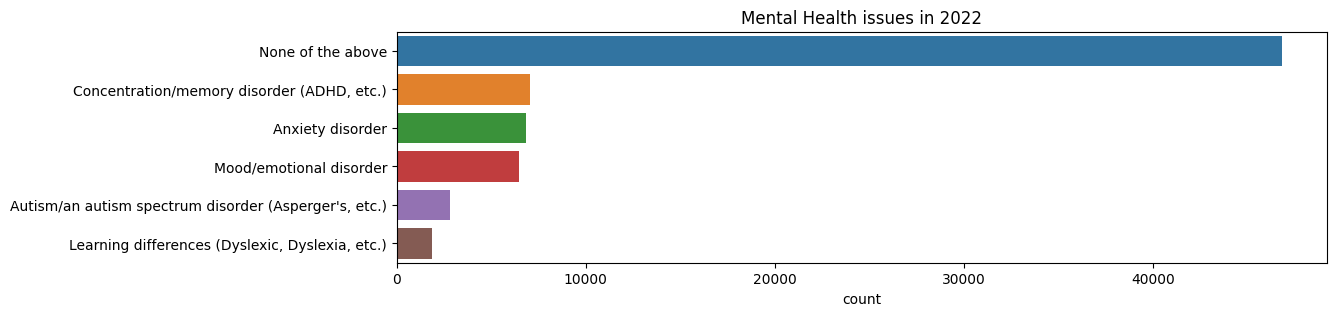

In [26]:
mental_health_states = split_cols(df_survey_2022.MentalHealth)
mental_health_states = mental_health_states.drop(["Or, in your own words:", "Prefer not to say"], axis=1)
mental_health_states = mental_health_states.rename(columns={
    "I have a mood or emotional disorder (e.g., depression, bipolar disorder, etc.)": "Mood/emotional disorder",
    "I have an anxiety disorder": "Anxiety disorder",
    "I have a concentration and/or memory disorder (e.g., ADHD, etc.)": "Concentration/memory disorder (ADHD, etc.)",
    "I have learning differences (e.g., Dyslexic, Dyslexia, etc.)": "Learning differences (Dyslexic, Dyslexia, etc.)",
    "I have autism / an autism spectrum disorder (e.g. Asperger's, etc.)": "Autism/an autism spectrum disorder (Asperger's, etc.)"})
mental_health_states_total = mental_health_states.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 3))
sns.barplot(x=mental_health_states_total, y=mental_health_states_total.index)
plt.title("Mental Health issues in 2022");
plt.xlabel('count');

As you can see, most people answered that they do not have any struggles with mental health, but there is a considerable percentage of people who suffer from concentration disorders, anxiety, and mood disorders.

## What is an average salary by countries?

It  is intriguing to observe the correlation between the interviewee's workplace country and the corresponding salary.

We can expect, that the highest salaries will appear in developed and progressive countries, such as: USA, Canada, United Kingdom, Germany, Australia, etc.

In [27]:
avg_salary_country = pd.DataFrame(df_survey_2022.groupby(["Country"]).ConvertedCompYearly.median()).reset_index()
data_avg_salary, layout_avg_salary = create_choropleth(avg_salary_country, "Country", "ConvertedCompYearly", "Average Salary by Countries", max_z=200000)
plot_choropleth(data_avg_salary, layout_avg_salary)

By calculating the median value of the salary for every country, we can see, that our predictions were quite right. The high average salary values among all countries are in the USA (\~145k), Israel (\~128k), Switzerland (\~114k), Australia (\~94k), Canada (\~94k), Iceland (\~92k), Norway (\~83k) and United Kingdom (\~83k).

However, we also can see some unpredicted high values as: Haiti (\~1.5M) and Lao People's Democratic Republic (\~120k). Let's see those observations more closely.

Firstly let's see the Haiti observations. As we can see the value of average salary there is \~1.5M, so we think that there can be either a problem with conversion of salary value to the USD currency, or it is just an outlier.

In [28]:
df_survey_2022.loc[df_survey_2022['Country'] == 'Haiti']

ConvertedCompYearly                            RemoteWork  \
31146                  NaN  Hybrid (some remote, some in-person)   
41234            1560600.0                        Full in-person   
47804                  NaN                        Full in-person   

                                                 EdLevel YearsCodePro  \
31146  Secondary school (e.g. American high school, G...            5   
41234       Bachelor’s degree (B.A., B.S., B.Eng., etc.)            5   
47804       Bachelor’s degree (B.A., B.S., B.Eng., etc.)          NaN   

                                                 DevType  \
31146              Developer, back-end;Developer, mobile   
41234                            Other (please specify):   
47804  Developer, front-end;Engineer, data;Developer,...   

                                              MainBranch  \
31146                     I am a developer by profession   
41234  I am not primarily a developer, but I write co...   
47804                        I code primarily as a hobby   

                                              Employment  \
31146  Independent contractor, freelancer, or self-em...   
41234                                Employed, full-time   
47804  Student, full-time;Not employed, but looking f...   

                                                 OrgSize Country  \
31146  Just me - I am a freelancer, sole proprietor, ...   Haiti   
41234                               100 to 499 employees   Haiti   
47804                                                NaN   Haiti   

                                  LanguageHaveWorkedWith              Age  \
31146                        C#;HTML/CSS;JavaScript;Ruby  25-34 years old   
41234  C;C#;HTML/CSS;Java;JavaScript;MATLAB;PHP;Pytho...              NaN   
47804  Assembly;Bash/Shell;C;C#;C++;Dart;Go;HTML/CSS;...  18-24 years old   

      Gender                                       MentalHealth  
31146    Man  I have an anxiety disorder;I have a concentrat...  
41234    Man                                  None of the above  
47804    Man                                  None of the above

As we can see, there are only 3 observations from Haiti and only 1 observation with non-Nan value of salary. Let's look at his (Gender = Men) information.
* Has Bachelor's degree
* Professionaly codes for 5 years
* No developer type given
* Employed full-time
* Not primary a developer, but codes
* Works in an average size company
* Knows and works with a lot of programming languages
* Age is not given

Even from this we can not be 100% sure, that this is wrong value of conversion, as he can be an outlier.

Just to check, let's see, what if we will convert the given value of the salary from Haitian Gourde to USD: \~1,5M $→$ \~11k

Now, let's look at the Laos observations.



In [29]:
df_survey_2022.loc[df_survey_2022['Country'] == "Lao People's Democratic Republic"]

ConvertedCompYearly      RemoteWork  \
3301                   NaN             NaN   
12329             120000.0    Fully remote   
30483                  NaN  Full in-person   
33768             159235.0    Fully remote   
36838                  NaN             NaN   
45858              57038.0    Fully remote   
57098                  NaN  Full in-person   

                                                 EdLevel YearsCodePro  \
3301                           Primary/elementary school          NaN   
12329    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)            4   
30483    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)            7   
33768    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)           20   
36838  Secondary school (e.g. American high school, G...          NaN   
45858    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)            2   
57098       Bachelor’s degree (B.A., B.S., B.Eng., etc.)          NaN   

                                                 DevType  \
3301                                                 NaN   
12329  Developer, front-end;Developer, full-stack;Dev...   
30483  Developer, front-end;Developer, full-stack;Dev...   
33768                                Developer, back-end   
36838                                                NaN   
45858  Developer, back-end;Product manager;Senior Exe...   
57098                               Developer, front-end   

                           MainBranch  \
3301      I code primarily as a hobby   
12329  I am a developer by profession   
30483  I am a developer by profession   
33768  I am a developer by profession   
36838     I code primarily as a hobby   
45858  I am a developer by profession   
57098           I am learning to code   

                                              Employment  \
3301                                  Student, full-time   
12329                                Employed, full-time   
30483                                Employed, part-time   
33768                                Employed, full-time   
36838                                 Student, part-time   
45858  Employed, full-time;Independent contractor, fr...   
57098                                Employed, full-time   

                                                 OrgSize  \
3301                                                 NaN   
12329                                   2 to 9 employees   
30483  Just me - I am a freelancer, sole proprietor, ...   
33768                                 20 to 99 employees   
36838                                                NaN   
45858                                   2 to 9 employees   
57098                                                NaN   

                                Country  \
3301   Lao People's Democratic Republic   
12329  Lao People's Democratic Republic   
30483  Lao People's Democratic Republic   
33768  Lao People's Democratic Republic   
36838  Lao People's Democratic Republic   
45858  Lao People's Democratic Republic   
57098  Lao People's Democratic Republic   

                                  LanguageHaveWorkedWith                 Age  \
3301                          HTML/CSS;JavaScript;Python  Under 18 years old   
12329  Go;HTML/CSS;JavaScript;Python;Ruby;SQL;TypeScript     25-34 years old   
30483                  C#;C++;Dart;JavaScript;PHP;Python     25-34 years old   
33768                                  Python;TypeScript     35-44 years old   
36838                     HTML/CSS;JavaScript;Python;SQL     18-24 years old   
45858                     HTML/CSS;JavaScript;Python;SQL     45-54 years old   
57098                                     JavaScript;PHP     18-24 years old   

      Gender       MentalHealth  
3301     Man  None of the above  
12329    Man  None of the above  
30483    Man  Prefer not to say  
33768    Man  None of the above  
36838    Man  None of the above  
45858    Man  None of the above  
57098    Man  None of the above

As we can see only 3 observations from Laos has salary value and by checking their information (25+; with Master's degree; work with many programming languages; are full-time employed, back/front-end developers), we can conclude, that these values (ConvertedCompYearly) are reasonable and can be just outliers in this country, as we have just a little sample.

## Additionally: Data Scientists' EDA

Let's look at the Data Scientist's responses more precisely. We can take almost two thousand answers that do not contain nan values for this.

In [30]:
# 'Data scientist or machine learning specialist'
dev_type_datasci= dev_type[dev_type['Data scientist or machine learning specialist'] == True].index.tolist()
dev_type_datasci
dev_data_scientists_df = df_survey_2022.iloc[dev_type_datasci]
dev_data_scientists_df.dropna()

ConvertedCompYearly                            RemoteWork  \
2                  40205.0  Hybrid (some remote, some in-person)   
41                 68160.0  Hybrid (some remote, some in-person)   
85                 95000.0  Hybrid (some remote, some in-person)   
94                 52769.0  Hybrid (some remote, some in-person)   
107                35000.0                        Full in-person   
...                    ...                                   ...   
72988             250000.0                          Fully remote   
73030              51336.0  Hybrid (some remote, some in-person)   
73072              39000.0  Hybrid (some remote, some in-person)   
73094              47772.0                          Fully remote   
73121              75384.0  Hybrid (some remote, some in-person)   

                                                 EdLevel YearsCodePro  \
2        Master’s degree (M.A., M.S., M.Eng., MBA, etc.)            5   
41     Secondary school (e.g. American high school, G...            3   
85          Bachelor’s degree (B.A., B.S., B.Eng., etc.)            7   
94            Other doctoral degree (Ph.D., Ed.D., etc.)            3   
107    Some college/university study without earning ...            5   
...                                                  ...          ...   
72988       Bachelor’s degree (B.A., B.S., B.Eng., etc.)            4   
73030    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)            6   
73072       Bachelor’s degree (B.A., B.S., B.Eng., etc.)            6   
73094    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)           16   
73121    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)            3   

                                                 DevType  \
2      Data scientist or machine learning specialist;...   
41     Data scientist or machine learning specialist;...   
85     Data scientist or machine learning specialist;...   
94     Data scientist or machine learning specialist;...   
107    Data scientist or machine learning specialist;...   
...                                                  ...   
72988  Data scientist or machine learning specialist;...   
73030  Data scientist or machine learning specialist;...   
73072  Data scientist or machine learning specialist;...   
73094  Data scientist or machine learning specialist;...   
73121  Data scientist or machine learning specialist;...   

                                              MainBranch  \
2      I am not primarily a developer, but I write co...   
41                        I am a developer by profession   
85                        I am a developer by profession   
94                        I am a developer by profession   
107                       I am a developer by profession   
...                                                  ...   
72988                     I am a developer by profession   
73030                     I am a developer by profession   
73072                     I am a developer by profession   
73094                     I am a developer by profession   
73121                     I am a developer by profession   

                                              Employment  \
2                                    Employed, full-time   
41                                   Employed, full-time   
85                                   Employed, full-time   
94                                   Employed, full-time   
107                                  Employed, full-time   
...                                                  ...   
72988                                Employed, full-time   
73030                                Employed, full-time   
73072                                Employed, full-time   
73094  Independent contractor, freelancer, or self-em...   
73121                                Employed, full-time   

                    OrgSize  \
2        20 to 99 employees   
41       20 to 99 employees   
85     100 to 499 employees   
94       20 to 99 employee

The majority of data scientists are found in the same countries as the other respondents (see the map below), although there is a noticeable underrepresentation of individuals from Africa.

In [31]:
countries = pd.DataFrame(dev_data_scientists_df.Country.value_counts()).reset_index()
data_country, layout_country = create_choropleth(countries, "index", "Country", "No. of Respondents in Countries")
plot_choropleth(data_country, layout_country)

The average age of data scientists is typically higher than the other respondent's.

In [32]:
px.histogram(dev_data_scientists_df, x="Age", title='Age of Respondents')

It seems that higher education is much more important for data scientists. Most of them have Master's degree, Bachelor's degree, or even doctoral degree.

In [33]:
px.histogram(dev_data_scientists_df, x="EdLevel", title='Education Level of Respondents')

Data scientists generally make the same amount of money as other developers. However, it's interesting that wages in Ukraine are relatively low when compared to the average pay for developers there. This outcome was likely influenced by the small number of responses from Ukraine.

In [34]:
avg_salary_country = pd.DataFrame(dev_data_scientists_df.groupby(["Country"]).ConvertedCompYearly.median()).reset_index()
data_avg_salary, layout_avg_salary = create_choropleth(avg_salary_country, "Country", "ConvertedCompYearly", "Average Salary by Countries", max_z=200000)
plot_choropleth(data_avg_salary, layout_avg_salary)

## Supplementary material for EDA

In [35]:
# generate the profiling report
profile = ProfileReport(
    df_survey_2022, title="Stack Overflow Annual Developer Survey", html={"style": {"full_width": True}}, sort=None
)

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

As we can see from dataset overview, there are some missing cells, some dublicate rows and almost all data is categorical, not numerical, so we would have to deal with Nan values, drop dublicate rows and convert categorical values using dummy variables for optimal usage and to avoid high cardinality.

Moreover, from this analysis we can see that there is a high correlation between *YearsCodePro* and *Age*.

The correlation matrix is also provided as a heatmap or table, and we can see that:
* On this stage the depending variable *ConvertedCompYearly* has either weak positive or no significant correlation to other variables. To check if this result is true, we are going to perform a t- and F-testing. This will clarify our hypothesis, if chosen factors are truly significant for determining annual salary.
* *EdLevel* and *MainBranch* have moderate positive correlation of 0.27
* *EdLevel* and *Age* have moderate positive correlation of 0.264
* *YearsCodePro* and *Age* have strong positive correlation of 0.507
* *MainBranch* and *Age* have moderate positive correlation of 0.328
* Other correlations are either weak or not significant

Those results can be significant for the model, but it is better to check the real significance of these correlations by testing.

## Key Takeaways

*  Almost the half of the observations have Nan value on our dependent variable *ConvertedCompYearly*, so we would use ~38k observations, which anyway should be enough.

*  Most respondents live in the English-speking countries, such as USA, India, Australia, and UK.

*  Almost the half of all respondents are at the age between 25 and 34 years (which could be expected). Which follows by two other big groups of people at ages 18-24 and 35-44.

*  Almost 94% of respondents are men.

*  Even if the Master's degree is prefered on interviews for the developer's job, almost the half of all respondents have only Bachelor's degree. Therefore, it is not needed to have Master's degree in computer science to be able to code professionaly.

*  Most popular roles are full-stack and back-end development positions. Front-end is on the third place.

*  The most popular programming languages to work with are: *JavaScript* and *HTML/CSS*. Followed by *SQL* and *Python*.

*  Overall, the community of developers uses over 40 different programming languages in the work.

* As was predicted, the highest values of average salary are in developed countries as *USA*, *Canada*, *Australia*, *United Kingdom*, *Switzerland*, *Iceland*, etc. But there were also unpredicted high results in *Haiti* and *Laos*.

* The working format is moslty either *Fully remote* or *Hybrid*.

* In correlation matrix it appeared, that the value of correlation between *YearsCodePro* and *Age* is 0.507, which denotes a strong positive correlation, so it should be tested for statistical significance.

* In the field of data science, Master's and Doctoral degrees are more common than Bachelor's degree. There is a higher average age for data scientists as a result. Additionally, we noticed that salaries in this field are quite low in Ukraine, though this may be due to a lack of responses from the country.